In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

e:\apps\anaconda\envs\dl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Skip-gram 模型的工作原理

1. **基本思想**：
   - 给定一个特定的单词，Skip-gram 模型的目标是预测其上下文中的单词。具体来说，模型试图预测在给定中心词（target word）的情况下，周围各个位置的单词是什么。

2. **输入和输出**：
   - **输入**：中心词（目标词）。
   - **输出**：上下文中的单词。上下文的大小通常由一个参数定义，称为窗口大小（window size）。

3. **训练过程**：
   - 对于训练集中的每个单词，模型考虑窗口内的周围单词，并试图预测它们。
   - 模型通常使用神经网络，网络中没有隐藏层（或者只有一个很小的隐藏层），输入层和输出层通过词向量连接。

4. **词嵌入（Word Embeddings）**：
   - 通过训练，模型学习到的词向量即为词嵌入。这些向量捕捉了词汇的语义特征，相似的词在向量空间中彼此接近。

5. **优化**：
   - 训练过程中，通常使用负采样（negative sampling）或层次 softmax（hierarchical softmax）来优化性能，特别是在词汇量很大的情况下。

### Skip-gram 模型的优点

1. **捕捉远程关系**：
   - Skip-gram 模型擅长捕捉更广泛的上下文信息，因此对于含有大量数据的大型语料库来说非常有效。

2. **高质量的词嵌入**：
   - 得到的词嵌入质量高，特别是对于频繁出现的单词。


In [2]:
batch_size = 2 # mini-batch size
embedding_size = 2 # embedding size

sentences = ["apple banana fruit", "banana orange fruit", "orange banana fruit",
                "dog cat animal", "cat monkey animal", "monkey dog animal"]

word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
voc_size = len(word_list)

# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
    # !注意这里上下文窗口！！！
    for w in context:
        skip_grams.append([target, w])

In [5]:
def random_batch():
    random_inputs = []
    random_labels = []
    # 第一个为抽样的序列，第二个参数指定抽样的数目， 第三个参数指定抽样元素是否可以重复
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        # *这里是妙手！独热妙手！
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels

In [7]:
# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # W and WT is not Traspose relationship
        self.W = nn.Linear(voc_size, embedding_size, bias=False) # voc_size > embedding_size Weight
        self.WT = nn.Linear(embedding_size, voc_size, bias=False) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X) # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer) # output_layer : [batch_size, voc_size]
        return output_layer

In [8]:
model = Word2Vec()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Training
for epoch in range(5000):
    input_batch, target_batch = random_batch()
    input_batch = torch.Tensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

C:\Users\hellow\AppData\Local\Temp\ipykernel_18208\3121481632.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  input_batch = torch.Tensor(input_batch)


Epoch: 1000 cost = 1.819231
Epoch: 2000 cost = 1.903309
Epoch: 3000 cost = 1.113725
Epoch: 4000 cost = 0.883874
Epoch: 5000 cost = 0.700056


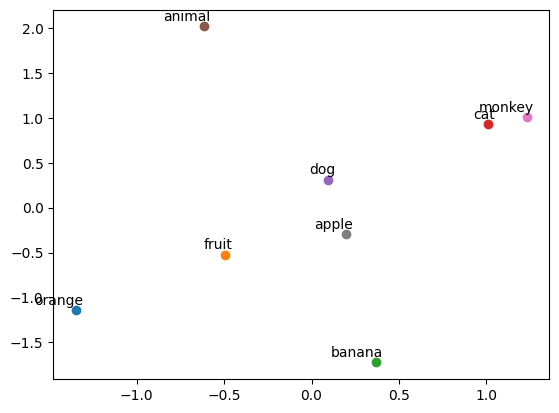

In [10]:
for i, label in enumerate(word_list):
    W, WT = model.parameters()
    x, y = W[0][i].item(), W[1][i].item()
    plt.scatter(x, y) # 在散点图上绘制了(x,y)这个点
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom') # 在每个点旁边添加了一个注释
    # 注释内容是label，
plt.show()